In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import save_image
from torchvision.transforms import ToPILImage, Resize
import torchvision.datasets as dset
to_img  = ToPILImage()
resize_img  = Resize(200)
def show_img(img):
    return resize_img(to_img(img))

cmap=plt.cm.tab10
c = cycler('color', cmap(np.linspace(0,1,10)))
plt.rcParams["axes.prop_cycle"] = c

%config InlineBackend.figure_format = 'retina'
%matplotlib notebook
%matplotlib notebook

%load_ext autoreload
%autoreload 2

def img_ae(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 64, 64)
    return x

In [131]:
%matplotlib inline

In [171]:
dataset = dset.ImageFolder(root='/scratch/rag394/data/gaussian_generator/',
                           transform=transforms.Compose([
                                   transforms.Grayscale(),
                                   transforms.Resize(128),
                                   transforms.CenterCrop(128),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,),(0.5,)),
                               ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                         shuffle=False, num_workers=8)

targets = pd.read_csv('/scratch/rag394/data/gaussian_generator/gaussian_parameters.csv').drop(['Unnamed: 0'], 1).values
targets = Variable(torch.from_numpy(targets).type(torch.FloatTensor), requires_grad=False)
targets = targets.cuda()

In [172]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(32*32*32, 4)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [173]:
model

CNN(
  (layer1): Sequential(
    (0): Conv2d (1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (layer2): Sequential(
    (0): Conv2d (16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (fc): Linear(in_features=32768, out_features=4)
)

In [174]:
model = CNN()
model.cuda()
optimizer = torch.optim.Adam(model.parameters(),lr=1.0e-3)
criterion = nn.SmoothL1Loss()
total_loss = []

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
    iter_mean = []
    for k, data in enumerate(dataloader):
        if k == 2000:
            break
        img, _ = data
        img = Variable(img).cuda()
        # ===================forward=====================
        output = model(img)
        loss   = criterion(output, targets[k,:])
        
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        iter_mean.append(loss.data[0])
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, np.mean(iter_mean)))
    total_loss.append(np.mean(iter_mean))

torch.save(model.state_dict(), '/scratch/rag394/data/ae/conv_gaussian_encoder.pth')

epoch [1/100], loss:0.0857
epoch [2/100], loss:0.0852
epoch [3/100], loss:0.0845
epoch [4/100], loss:0.0842
epoch [5/100], loss:0.0842
epoch [6/100], loss:0.0837
epoch [7/100], loss:0.0831
epoch [8/100], loss:0.0821
epoch [9/100], loss:0.0816
epoch [10/100], loss:0.0807
epoch [11/100], loss:0.0801
epoch [12/100], loss:0.0794
epoch [13/100], loss:0.0791
epoch [14/100], loss:0.0784
epoch [15/100], loss:0.0783
epoch [16/100], loss:0.0783
epoch [17/100], loss:0.0781
epoch [18/100], loss:0.0777
epoch [19/100], loss:0.0769
epoch [20/100], loss:0.0767
epoch [21/100], loss:0.0757
epoch [22/100], loss:0.0756
epoch [23/100], loss:0.0749


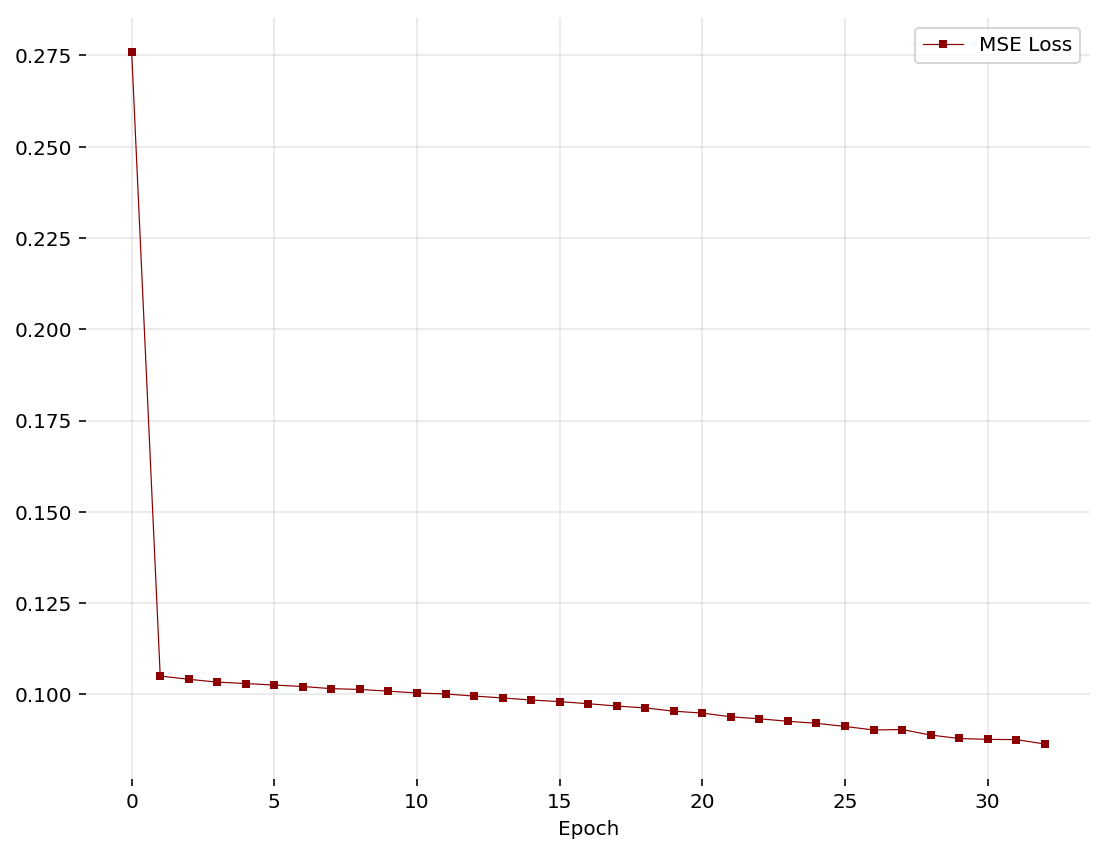

In [176]:
fig, ax = plt.subplots(figsize=(9,7))
pd.Series(total_loss, name='MSE Loss').plot(ax=ax,color='darkred', 
                                            lw=0.6, marker='s', markersize=3., legend=True)
ax.grid(alpha=0.2)
ax.set_xlabel('Epoch')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_alpha(False)
ax.grid(alpha=0.3)

/home/rag394/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: covariance is not positive-semidefinite.
  from ipykernel import kernelapp as app


Variable containing:
 1.0486  1.1484
 1.1484  1.4069
[torch.cuda.FloatTensor of size 2x2 (GPU 0)]
 Variable containing:
 0.8066  0.0031
 0.0024  0.6448
[torch.cuda.FloatTensor of size 2x2 (GPU 0)]

[0.40275946]


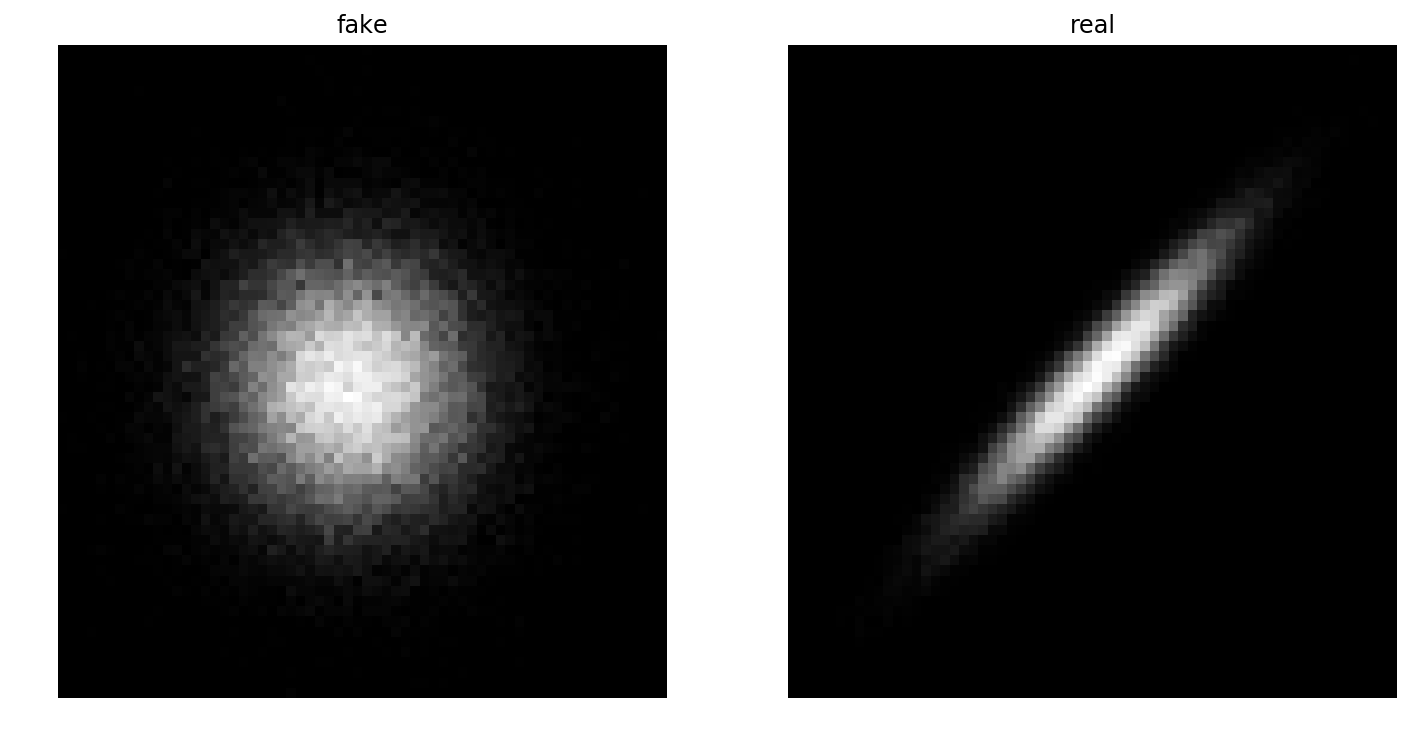

In [178]:
for k, data in enumerate(dataloader):
        if k == 7:
            img, _ = data
            img = Variable(img).cuda()
            real = targets[k,:]
            output = model(img)
            error = criterion(output, real)
            break

cov_fake = output.view(2,2)
cov_real = real.view(2,2)

fig, ax = plt.subplots(ncols=2, figsize=(12,6),frameon=False)

x, y = np.random.multivariate_normal([0, 0], cov_fake.data.cpu().numpy(), 50000).T

ax[0].hist2d(x,y,bins=64,cmap='Greys_r');
ax[0].axis('off')
ax[0].set_title('fake')

x, y = np.random.multivariate_normal([0, 0], cov_real.data.cpu().numpy(), 50000).T

ax[1].hist2d(x,y,bins=64,cmap='Greys_r');
ax[1].axis('off')
ax[1].set_title('real')

print(cov_real, cov_fake);
print(error.data.cpu().numpy())

### Notes 

In [ ]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1), # b, 8, 2, 2
            nn.Linear(200,4))
        
        self.decoder = nn.Sequential(
            nn.Linear(4,200),
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh())

    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        
        return enc, dec

In [ ]:
class GaussianModel(nn.Module):
    def __init__(self):
        super(GaussianModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, stride=3, padding=1)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 4)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x